In [ ]:
!pwd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import sys
import itertools
from collections import Counter, defaultdict
import numpy as np
import scipy.stats, scipy.spatial, scipy.signal
import os
import json
from path import Path; Path.stem = Path.namebase
from natsort import natsorted

from ppm3d import Cluster, align, AlignedData
from motifextraction import load_cns
from motifextraction.utils import get_norm_factors, FractionalCounter

In [2]:
# Set up some paths to load data from
# The motifs I used here were just to do some basic testing.

data_path = Path(".../motifextraction/examples/motifextraction/metallic_glass/data")
cluster_path = data_path / "clusters"
motif_path = data_path / "averaged"
motif_errors_path = data_path / "motif_errors"
errors_path = data_path / "errors"

In [3]:
# Load the CNs of the clusters and set the total number of clusters
cluster_cns = load_cns(cluster_path).astype(int)
NCLUSTERS = len(cluster_cns)
print(NCLUSTERS)
print(Counter(cluster_cns))

Loading cns...
9826
Counter({15: 2293, 14: 2030, 11: 1534, 10: 1202, 13: 854, 12: 821, 16: 768, 9: 216, 17: 99, 8: 8, 18: 1})


In [4]:
motif_fns = natsorted(motif_path.glob("*.xyz"))
motif_fns = [f for f in motif_fns if not f.stem.startswith("ignore")]
NMOTIFS = len(motif_fns)
print(NMOTIFS)

17


In [5]:
motifs = [Cluster(filename=fn) for fn in motif_fns]

In [6]:
motif_cns = np.array([motif.CN for motif in motifs])
motifs_by_cn = defaultdict(list)
for motif in motifs:
    motifs_by_cn[motif.CN].append(motif)

for cn in sorted(Counter(motif_cns).keys()):
    for motif in motifs_by_cn[cn]:
        print(cn, motif.filename.stem, motif.vp_index[:4])

9 averaged_13 (0, 3, 6, 0)
9 averaged_1600K_CN9_manual (0, 3, 6, 0)
10 averaged_7 (0, 2, 8, 0)
10 averaged_1600K_CN10_manual (0, 3, 6, 1)
11 averaged_12 (0, 2, 8, 1)
12 Z12_FK (0, 0, 12, 0)
12 averaged_1 (0, 2, 8, 2)
12 averaged_8 (0, 3, 6, 3)
12 averaged_11 (0, 3, 6, 3)
13 averaged_0 (0, 1, 10, 2)
14 averaged_6 (0, 0, 12, 2)
14 averaged_9 (0, 1, 10, 3)
14 averaged_14 (0, 2, 8, 4)
14 averaged_15 (0, 0, 12, 2)
15 averaged_3 (0, 1, 10, 4)
15 averaged_16 (0, 0, 12, 3)
16 averaged_2 (0, 0, 12, 4)


In [7]:
# Load norm factors so we can correctly normalize the motif errors.
# The norm factors are calculated using the all-to-all alignments.
with open(data_path / "norm_factors.json") as f:
    _norm_factors = json.load(f)
    L2_norm_factors = _norm_factors["L2"]
    L1_norm_factors = _norm_factors["L1"]
    Linf_norm_factors = _norm_factors["Linf"]
    angular_norm_factors = _norm_factors["angular"]

In [8]:
# Load motif errors
motif_errors = np.zeros((NMOTIFS, NCLUSTERS, 4))
motif_errors.fill(np.nan)
for i, fn in enumerate(motif_fns):
    stem = '_'.join(fn.namebase.split('_')[:])
    efn = motif_errors_path / (stem + '_errors.npy')
    motif_errors[i, :, :] = np.load(efn)

motif_errors[:, :, 0]
motif_errors[:, :, 0][np.where(motif_errors[:, :, 0] > L2_norm_factors['set_to_inf_before_dividing'])] = np.inf
motif_errors[:, :, 0][np.isinf(motif_errors[:, :, 0])] = np.nan
motif_errors[:, :, 0] /= L2_norm_factors['divide_by']

motif_errors[:, :, 1]
motif_errors[:, :, 1][np.where(motif_errors[:, :, 1] > L1_norm_factors['set_to_inf_before_dividing'])] = np.inf
motif_errors[:, :, 1][np.isinf(motif_errors[:, :, 1])] = np.nan
motif_errors[:, :, 1] /= L1_norm_factors['divide_by']

motif_errors[:, :, 2]
motif_errors[:, :, 2][np.where(motif_errors[:, :, 2] > Linf_norm_factors['set_to_inf_before_dividing'])] = np.inf
motif_errors[:, :, 2][np.isinf(motif_errors[:, :, 2])] = np.nan
motif_errors[:, :, 2] /= Linf_norm_factors['divide_by']

motif_errors[:, :, 3]
motif_errors[:, :, 3][np.where(motif_errors[:, :, 3] > angular_norm_factors['set_to_inf_before_dividing'])] = np.inf
motif_errors[:, :, 3][np.isinf(motif_errors[:, :, 3])] = np.nan
motif_errors[:, :, 3] /= angular_norm_factors['divide_by']

motif_errors = scipy.stats.gmean(motif_errors, axis=2)
print(motif_errors.shape)  # Will have shape (NMOTIFS, NCLUSTERS)

for i, motif in enumerate(motifs):
    motif.errors = motif_errors[i, :]

(17, 9826)


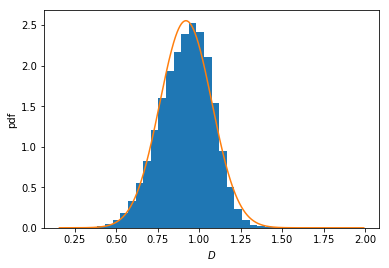

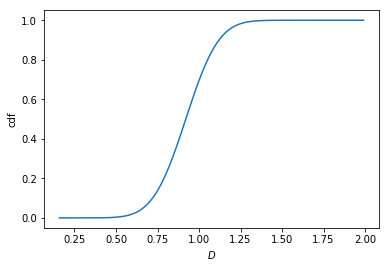

In [9]:
# Fit the distribution of motif errors to a normal distribution using scipy.
# Plot the PDF and the CDF of the distribution to get a feel for what a "low" D value is, and what a "high" D value is.
# For example, for this data, "low" likely falls somewhere between 0.50 and 0.70.
# The CDF is an alternative representation of that.
#  The CDF is useful because it gives us an ~ "percentage of being similar" number between 0 and 1.
#  This is useful for setting a cutoff for what it means to be "similar".
plt.hist(motif_errors[~np.isnan(motif_errors)], bins=40, density=True)
m, s = np.nanmean(motif_errors), np.nanstd(motif_errors)
norm = scipy.stats.norm(m, s)
X = np.arange(np.nanmin(motif_errors), np.nanmax(motif_errors), 0.001)
plt.xlabel("$D$")
plt.ylabel("pdf")
plt.plot(X, norm.pdf(X))
plt.show()
plt.xlabel("$D$")
plt.ylabel("cdf")
plt.plot(X, norm.cdf(X))
plt.show()

In [10]:
cutoff = 3.6  # Use the first valley in G(r) to set this cutoff.
def calculate_gmean(aligned_data):
    data = aligned_data
    L1, L2, Linf, angular = data.L1Norm(), data.L2Norm(), data.LinfNorm(), data.angular_variation(neighbor_cutoff=cutoff)
    L2 /= L2_norm_factors['divide_by']
    L1 /= L1_norm_factors['divide_by']
    Linf /= Linf_norm_factors['divide_by']
    angular /= angular_norm_factors['divide_by']
    g = scipy.stats.gmean((L2, L1, Linf, angular))
    return g

9
0.0460662796754 0.657183552603 averaged_13 averaged_1600K_CN9_manual
0.0588076790476 0.675832101892 averaged_1600K_CN9_manual averaged_13


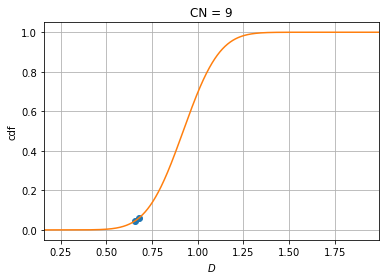

10
0.00412268517431 0.507611064551 averaged_7 averaged_1600K_CN10_manual
0.0029298146764 0.489854609213 averaged_1600K_CN10_manual averaged_7


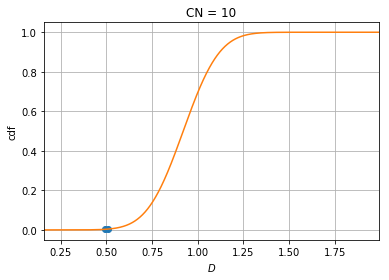

11
12
0.901230388972 1.12152838272 Z12_FK averaged_1
0.999606145357 1.44461574595 Z12_FK averaged_8
0.99907256189 1.40641940821 Z12_FK averaged_11
0.836042268377 1.07306522641 averaged_1 Z12_FK
0.0976774265614 0.717998886187 averaged_1 averaged_8
0.185810764975 0.78070496357 averaged_1 averaged_11
0.998976968973 1.40187847955 averaged_8 Z12_FK
0.0941322553877 0.714745203074 averaged_8 averaged_1
0.302142096544 0.83930795877 averaged_8 averaged_11
0.999524349035 1.43641059718 averaged_11 Z12_FK
0.168406899762 0.770233683835 averaged_11 averaged_1
0.281666378147 0.829991094456 averaged_11 averaged_8


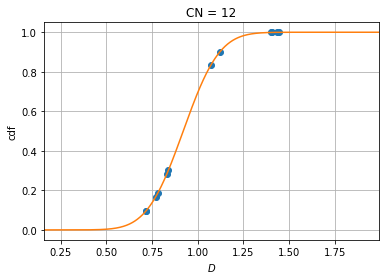

13
14
0.0140017239192 0.577057894991 averaged_6 averaged_9
0.0468009831667 0.658364120648 averaged_6 averaged_14
0.175535535235 0.774601842189 averaged_6 averaged_15
0.0155242813355 0.583428836133 averaged_9 averaged_6
0.0337440413106 0.63466713631 averaged_9 averaged_14
0.020097092848 0.599782797942 averaged_9 averaged_15
0.0616231906379 0.679513980832 averaged_14 averaged_6
0.025365825723 0.615090716279 averaged_14 averaged_9
0.0851837385265 0.706108622613 averaged_14 averaged_15
0.153122764129 0.760447734258 averaged_15 averaged_6
0.0182113337259 0.593467906165 averaged_15 averaged_9
0.0847912071617 0.705714567802 averaged_15 averaged_14


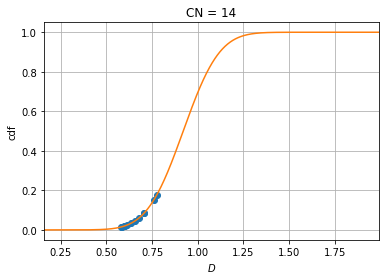

15
0.068950255056 0.688516215918 averaged_3 averaged_16
0.0810170996559 0.701854067936 averaged_16 averaged_3


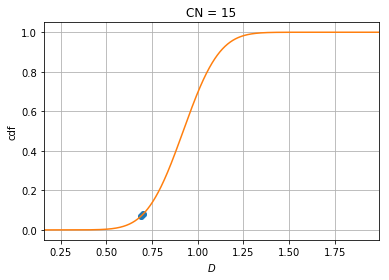

16


In [11]:
# Align every motif to every other motif with the same CN.
#  Plot the alignment scores (D) on the CDF curve. This helps us get a feel for how similar the motifs are to one another.
for cn in sorted(motifs_by_cn.keys()):
    print(cn)
    cs = []
    for m1 in motifs_by_cn[cn]:
        for m2 in motifs_by_cn[cn]:
            if m1 == m2:
                continue
            data = align(m1.filename, m2.filename)
            data = AlignedData.from_mapping(data)
            g = calculate_gmean(data)
            c = norm.cdf(g)
            cs.append((g, c))
            print(c, g, m1.filename.stem, m2.filename.stem)
    if cs:
        x, y = zip(*sorted(cs))
        x, y = list(x), list(y)
        plt.xlabel("$D$")
        plt.ylabel("cdf")
        plt.title(f"CN = {cn}")
        plt.plot(x, y, 'o')
        plt.plot(X, norm.cdf(X))
        plt.xlim([np.amin(X), np.amax(X)])
        plt.grid()
        plt.show()

In [12]:
def merge_sets(tuple_list):
    """Given a list of tuples, some of which may have common elements, combine the tuples into disjoint tuples."""
    iset = set([frozenset(s) for s in tuple_list])  # Convert to a set of sets
    result = []
    while(iset):                  # While there are sets left to process:
        nset = set(iset.pop())      # Pop a new set
        check = len(iset)           # Does iset contain more sets
        while check:                # Until no more sets to check:
            check = False
            for s in iset.copy():       # For each other set:
                if nset.intersection(s):  # if they intersect:
                    check = True            # Must recheck previous sets
                    iset.remove(s)          # Remove it from remaining sets
                    nset.update(s)          # Add it to the current set
        result.append(tuple(nset))  # Convert back to a list of tuples 
    return result

In [13]:
def assign(c, motifs, cluster_cn):
    """Assigned a cluster C to a motif. Input is the cluster index, output is the motif index.
    Constrain assignments to the same CN."""
    e = np.inf
    idx = np.nan
    for i, motif in enumerate(motifs):
        if np.abs(cluster_cn - motif.CN) > 0:  # Enforce CN similarity +- 0
            continue
        if motif.errors[c] < e:
            e = motif.errors[c]
            idx = i
    return idx, e

#assignments = np.zeros((NCLUSTERS))
#assignments.fill(np.nan)
#for c in range(NCLUSTERS):
#    assignments[c] = assign(c, motifs, cluster_cns[c])[0]

In [14]:
# The goal now is to identify a *unique* "basis set" of motifs that accuracy describes the structure of the system.
#  There are two big problems to solve. First, What does "unique" mean? Or in other words, what does it mean for
#   two clusters to be so similar that we should consider them identical? The above CDF plots help us determine this.
#   In my experience, a CDF cutoff of ~ 0.015 works reasonably well.
#  Second, What does it mean to have a set of motifs that "accurately describe the structure of the system"?
#   You can come up with whatever definition fits your use case. I have chosen to use the idea that the best basis
#   set is one that most precisely represents the clusters in the glass. I have defined this as the set of unique
#   clusters that have the loweset total mean D after assignment of each cluster to each motif.
#   More concretely, I minimize:
#      MEAN[ MEAN[D(cluster, motif) for all clusters assigned to the motif] for all motifs]
#    subject to the constraint that the motifs are unique.
#  To implement this algorithm, we need to assign each cluster to each motif every time we test a new basis set.
#   To start, we have some motifs that are non-unique, call them for example motif A and motif B.
#   Because motifs A and B have the same structure, we need to remove one of them. Which one do we remove?
#   We remove the one that represents most _poorly_ the clusters that were assigned to it.
#   This motivates the "choose_worst_motif" function below.
#   The "choose_best_motif" is implemented similarly, but not used here.

In [15]:
def choose_best_motif(motifs):
    motifs = list(motifs)
    
    assignments = np.zeros((NCLUSTERS))
    assignments.fill(np.nan)
    for c in range(NCLUSTERS):
        assignments[c] = assign(c, motifs, cluster_cns[c])[0]
    
    means = []
    for motif in motifs:
        #m = np.nanmean(motif.errors[np.where(cluster_cns == motif.CN)])
        m = np.nanmean(motif.errors[np.where(assignments == i)])
        means.append(m)
    k = np.argmin(means)
    return motifs[k]

def choose_worst_motif(motifs):
    motifs = list(motifs)
    
    assignments = np.zeros((NCLUSTERS))
    assignments.fill(np.nan)
    for c in range(NCLUSTERS):
        assignments[c] = assign(c, motifs, cluster_cns[c])[0]
    
    means = []
    for i, motif in enumerate(motifs):
        #m = np.nanmean(motif.errors[np.where(cluster_cns == motif.CN)])
        m = np.nanmean(motif.errors[np.where(assignments == i)])
        means.append(m)
    k = np.argmax(means)
    return motifs[k]

In [16]:
def calculate_basis(motifs, cdf_cutoff):
    consider_these = list(motifs)
    
    # First calculate all the alignment scores
    alignment_scores = {}
    for m1 in consider_these:
        for m2 in consider_these:
            if m1 == m2:
                continue
            data = align(m1.filename, m2.filename)
            data = AlignedData.from_mapping(data)
            g = calculate_gmean(data)
            c = norm.cdf(g)
            if c < cdf_cutoff:
                print(c, m1.filename.stem, m2.filename.stem)
            alignment_scores[tuple(sorted((m1.filename.stem, m2.filename.stem)))] = c
            
    while True:
        identical = set()
        for m1 in consider_these:
            for m2 in consider_these:
                if m1 == m2:
                    continue
                f1, f2 = m1.filename.stem, m2.filename.stem
                c = alignment_scores[tuple(sorted((f1,f2)))]
                if c < cdf_cutoff:
                    a = frozenset({m1, m2})
                    identical.add(a)
        identical = merge_sets(identical)
        print('"identical" motifs:')
        for subset in identical:
            print("  ", [motif.filename.stem for motif in subset])

        remove = []
        for subset in identical:
            motif = choose_worst_motif(subset)
            remove.append(motif)
        print(f"Removing: {[motif.filename.stem for motif in remove]}")
        for r in remove:
            for motif in consider_these:
                if motif is r:
                    consider_these.remove(motif)
                    break
        if not remove:
            return consider_these

In [17]:
cdf_cutoff = 0.015

BASIS = []
for CN in sorted(motifs_by_cn.keys()):
    print(f"CN {CN} has {len(motifs_by_cn[CN])} motifs")
    basis = calculate_basis(motifs_by_cn[CN], cdf_cutoff)
    print(f"Basis for CN {CN}: {[motif.filename.stem for motif in basis]}")
    BASIS.extend(basis)

CN 9 has 2 motifs
"identical" motifs:
Removing: []
Basis for CN 9: ['averaged_13', 'averaged_1600K_CN9_manual']
CN 10 has 2 motifs
0.00412268517431 averaged_7 averaged_1600K_CN10_manual
0.0029298146764 averaged_1600K_CN10_manual averaged_7
"identical" motifs:
   ['averaged_7', 'averaged_1600K_CN10_manual']
Removing: ['averaged_1600K_CN10_manual']
"identical" motifs:
Removing: []
Basis for CN 10: ['averaged_7']
CN 11 has 1 motifs
"identical" motifs:
Removing: []
Basis for CN 11: ['averaged_12']
CN 12 has 4 motifs
"identical" motifs:
Removing: []
Basis for CN 12: ['Z12_FK', 'averaged_1', 'averaged_8', 'averaged_11']
CN 13 has 1 motifs
"identical" motifs:
Removing: []
Basis for CN 13: ['averaged_0']
CN 14 has 4 motifs
0.0140017239192 averaged_6 averaged_9
"identical" motifs:
Removing: []
Basis for CN 14: ['averaged_6', 'averaged_9', 'averaged_14', 'averaged_15']
CN 15 has 2 motifs
"identical" motifs:
Removing: []
Basis for CN 15: ['averaged_3', 'averaged_16']
CN 16 has 1 motifs
"identical

In [18]:
print(len(BASIS))
for motif in BASIS:
    print(motif.CN, motif.vp_index[:4], motif.filename.stem)

16
9 (0, 3, 6, 0) averaged_13
9 (0, 3, 6, 0) averaged_1600K_CN9_manual
10 (0, 2, 8, 0) averaged_7
11 (0, 2, 8, 1) averaged_12
12 (0, 0, 12, 0) Z12_FK
12 (0, 2, 8, 2) averaged_1
12 (0, 3, 6, 3) averaged_8
12 (0, 3, 6, 3) averaged_11
13 (0, 1, 10, 2) averaged_0
14 (0, 0, 12, 2) averaged_6
14 (0, 1, 10, 3) averaged_9
14 (0, 2, 8, 4) averaged_14
14 (0, 0, 12, 2) averaged_15
15 (0, 1, 10, 4) averaged_3
15 (0, 0, 12, 3) averaged_16
16 (0, 0, 12, 4) averaged_2


In [19]:
# Print my (re)move commands

for motif in motifs:
    if motif not in BASIS:
        print(f"mv {motif.filename.name} ignore_{motif.filename.name}")

mv averaged_1600K_CN10_manual.xyz ignore_averaged_1600K_CN10_manual.xyz
